In [1]:
# LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt # Visualization
import seaborn as sb # Visualization
import PIL #Image viewer

# import glob to return all file paths that match a specific pattern
import os
from glob import glob
import itertools

# for Compatibility
from __future__ import print_function, division
from builtins import range, input

# Include tensorflow keras layers, models, and preprocessing

from tensorflow import keras 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, \
Activation, add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

#Importing confusion matrix to describe the performance of the model
from sklearn.metrics import confusion_matrix

# Using Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2.3.0


In [2]:
# Include the directories of the dataset
train_path = '../Dataset/blood_cell_images/TRAIN'
valid_path = '../Dataset/blood_cell_images/TEST'

In [3]:
# Get the files from the directories
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
folders = glob(train_path + '/*')

In [4]:
# Check the length of training data
print(len(image_files))

9957


In [5]:
# Check the length of validation data
print(len(valid_image_files))

2487


In [6]:
# Check the number of classes
print(len(folders))

4


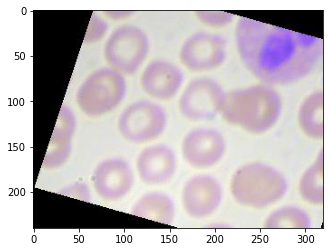

In [7]:
# View a sample image
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

In [9]:
# training config:
epochs = 2 # Increase the epochs or use callbacks
batch_size = 128

IMPLEMENTATION OF RESNET

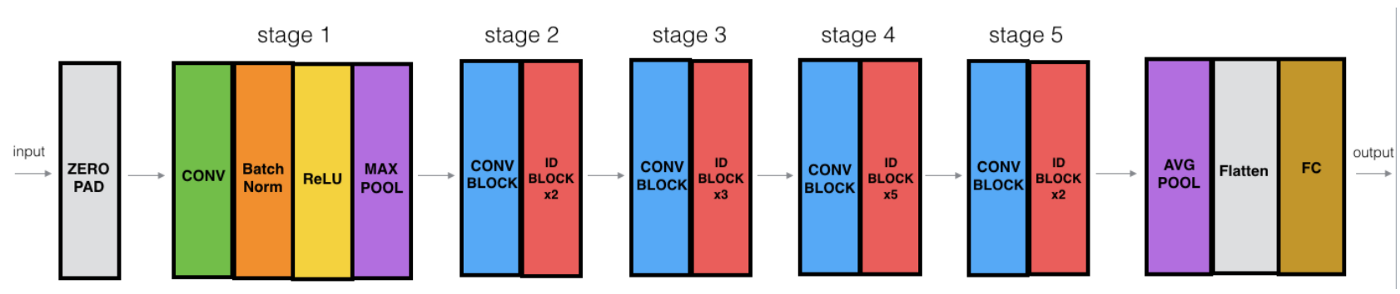

Residual layer looks like: Approximates the identity function. f(x) is minimised to 0, such that the network learns the identity function.

During backpropagation, the gradient can flow throught the skip connection, and avoids the problem of vanishing gradients.

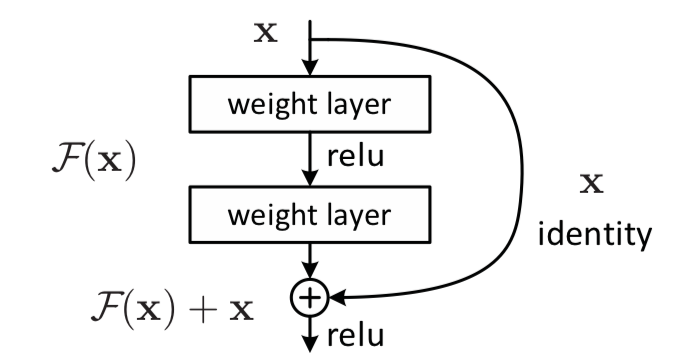

We have to implement two layers:
1. Identity block
2. Conv block

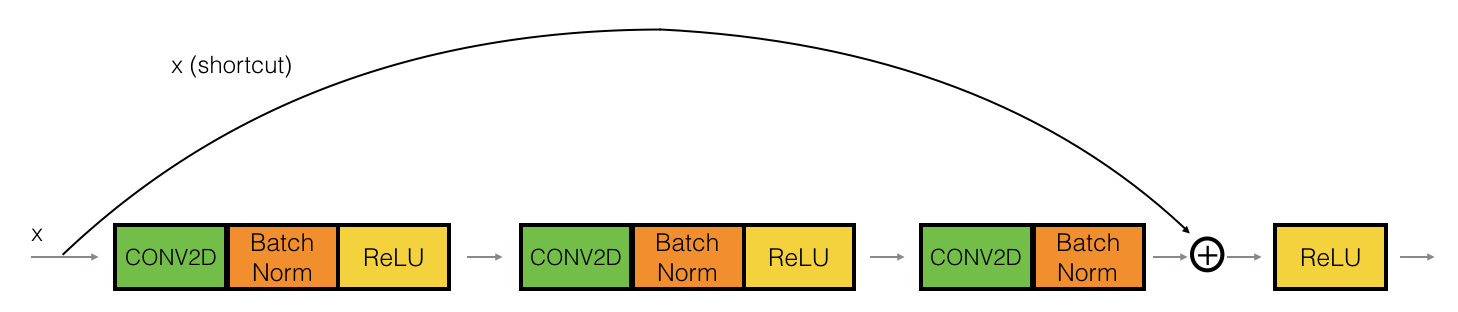

In [10]:
def identity_block(input, kernel_size, filters):
    f1, f2, f3 = filters
    
    # 'he_normal' draws samples from a truncated normal distribution .
    x = Conv2D(f1, (1,1), kernel_initializer = 'he_normal')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size, padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, (1, 1), kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    
    # input is directly connected
    x_shortcut = input
    
    x = add([x, x_shortcut])
    
    x = Activation('relu')(x)
    return x

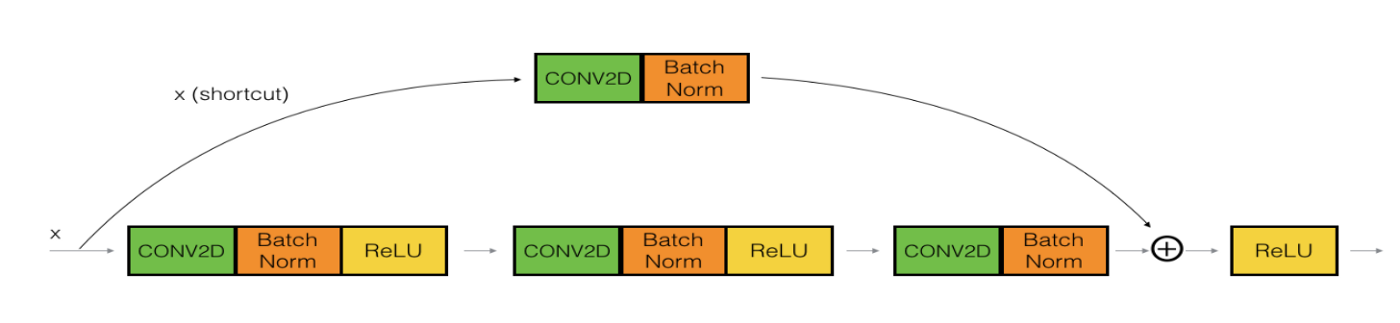

In [11]:
def conv_block(input, kernel_size, filters, strides= (2,2)):
    f1, f2, f3 = filters
    
    # 'he_normal' draws samples from a truncated normal distribution .
    x = Conv2D(f1, (1,1), strides = strides, kernel_initializer = 'he_normal')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size, padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, (1, 1), kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    
    # shortcut connection
    x_shortcut = Conv2D(f3, (1, 1), strides = strides, kernel_initializer = 'he_normal')(input)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    x = add([x, x_shortcut])
    
    x = Activation('relu')(x)
    return x

In [12]:
def ResNet50(IMAGE_SIZE, folders):

    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    folder -- for the number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    i = Input(shape=IMAGE_SIZE + [3])
    # Zero-Padding
    x = ZeroPadding2D((3, 3))(i)
    
    # Stage 1
    x = Conv2D(64, (7, 7),
               strides=(2, 2),
               padding='valid',
               kernel_initializer='he_normal'
               )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])
    
    #Stage 3
    x = conv_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    
    #Stage 4
    x = conv_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    
    #Stage 5
    x = conv_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    
    # AVGPOOL 
    x = AveragePooling2D()(x)
    
    x = Flatten()(x)
    x = Dense(len(folders), activation='softmax')(x)
    
    # Create model
    model = Model(inputs = i, outputs = x, name='ResNet50')
    
    return model
    

In [13]:
model = ResNet50(IMAGE_SIZE, folders)

In [14]:
# view the structure of the model
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
___________________________________________________________________________________________

In [15]:
# compile the model with loss and optimizer specified
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [21]:
# create an instance of ImageDataGenerator
# VALUES BETWEEN -1 TO 1
def preprocess_input_(x):
    x /= 127.5
    x -= 1.
    return x

train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input_
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input_
)

In [22]:
# test generator to see how it works and some other useful things
# get label mapping for confusion matrix plot later

test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -1.0 max: 0.9764706
(224, 224, 3)


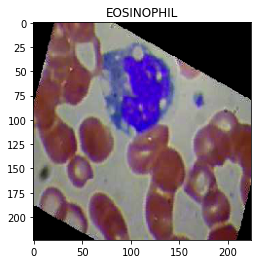

In [25]:
# should be NOT a strangely colored image
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    print(x[0].shape)
    plt.imshow(x[0])
    plt.show()
    break

In [26]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
# fit the model
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(train_generator, 
             validation_data = valid_generator,
             epochs = epochs,
             steps_per_epoch = len(image_files) // batch_size,
             validation_steps= len(valid_image_files) // batch_size,
             callbacks = [
                 EarlyStopping(monitor = 'loss', patience = 3, restore_best_weights= True),
                 ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, monitor='val_accuracy',
                                  mode='max', save_best_only=True )
             ]
             )

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()